# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 5. Face Detection and Emotion Recognition (Курсовая работа)

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

*(Усложненное задание) Все тоже самое, но воспользоваться этим датасетом:
https://fitnessallyapp.com/datasets/jester/v1

# Часть 1. Обучение модели

In [157]:
import os
import time
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import shutil

from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

%matplotlib inline

In [158]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Для обхода бага библиотек

### Загрузка датасета и разделение на тестовую и обучающие выборки

In [159]:
# Распределим файлы в правильные папки, чтобы ImageFolder правильно определил классы по названиям папок
if 1 == 2:
    source = "C:/Temp/leapGestRecog_source/"
    dest = "C:/Temp/leapGestRecog/"

    for i in range(10):
        for k, j in enumerate(os.listdir(source + f"0{i}")):
            if os.path.exists(dest + f"{k}") == False:
                os.mkdir(dest + f"{k}")
            for f in os.listdir(source + f"0{i}/{j}"):
                shutil.copy(source + f"0{i}/{j}/{f}", dest + f"{k}/{f}")

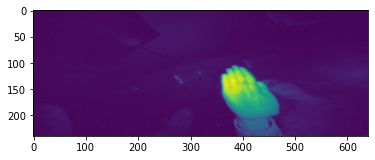

(240, 640)

In [160]:
# Посмотрим на один из жестов
im = plt.imread('C:/temp/leapGestRecog/0/frame_00_01_0001.png')
plt.imshow(im)
plt.show()
im.shape

In [161]:
channels = 1 # Число каналов
classes = 10 # Число классов
size_n = 256 # Размер первого слоя
size_p = 128 # Размер картинки
BATCH_SIZE = 10 # Размер пакета

In [162]:
# Трансформации
transforms = tt.Compose([# Настройки для расширения датасета
                         tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.Resize((size_p,size_p), interpolation=Image.NEAREST),
                         tt.ToTensor(),
                         tt.Normalize((0.1307,), (0.3081,)),
])                      # Приведение к тензору

In [163]:
# Классы
digit_to_classname = {0: 'palm', 
                      1: 'I', 
                      2: 'fist', 
                      3: 'fist_moved', 
                      4: 'thumb', 
                      5: 'index', 
                      6: 'ok',
                      7: 'palm_moved',
                      8: 'c',
                      9: 'down'}

In [164]:
# Загрузка датасета
dataset = ImageFolder('C:/Temp/leapGestRecog', transforms)

In [165]:
dataset.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [166]:
dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: C:/Temp/leapGestRecog
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               Resize(size=(128, 128), interpolation=PIL.Image.NEAREST)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

(tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]), 0)
torch.Size([1, 128, 128])
0


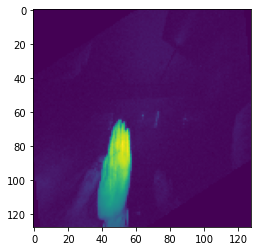

In [167]:
for i in dataset:
    print(i)
    print(i[0].shape)
    print(i[1])
    plt.imshow(i[0][0])
    plt.show()
    break

In [168]:
# Делим на трейн и тест
index_train, index_test = train_test_split(range(len(dataset)), test_size=0.3, random_state=42)

In [169]:
sampler_train = SubsetRandomSampler(index_train)
sampler_test = SubsetRandomSampler(index_test)

loader_train = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_train, pin_memory=True)
loader_test = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_test, pin_memory=True)

### Обучение

In [170]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [171]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes, size_n, size_p, debug):
        super().__init__()
        
        self.debug = debug
        
        size_pre = in_channels
        size_cur = size_n
        size_c = size_p / 2
        self.conv1 = self.conv_block(size_pre, size_cur)
        self.conv2 = self.conv_block(size_cur, size_cur, pool=True)
        self.drop11 = nn.Dropout(0.25)
        self.res1 = nn.Sequential(self.conv_block(size_cur, size_cur), self.conv_block(size_cur, size_cur))
        self.drop1 = nn.Dropout(0.5)
        
        size_pre = size_cur
        size_cur = size_cur * 2
        size_c = size_c / 2
        self.conv3 = self.conv_block(size_pre, size_cur)
        self.conv4 = self.conv_block(size_cur, size_cur, pool=True)
        self.drop12 = nn.Dropout(0.25)
        self.res2 = nn.Sequential(self.conv_block(size_cur, size_cur), self.conv_block(size_cur, size_cur))
        self.drop2 = nn.Dropout(0.5)
        
        size_pre = size_cur
        size_cur = size_cur * 2
        size_c = size_c / 2
        self.conv5 = self.conv_block(size_pre, size_cur)
        self.conv6 = self.conv_block(size_cur, size_cur, pool=True)
        self.drop13 = nn.Dropout(0.25)
        self.res3 = nn.Sequential(self.conv_block(size_cur, size_cur), self.conv_block(size_cur, size_cur))
        self.drop3 = nn.Dropout(0.5)

        #size_pre = size_cur
        #size_cur = size_cur * 2
        #size_c = size_c / 2
        #self.conv7 = self.conv_block(size_pre, size_cur)
        #self.conv8 = self.conv_block(size_cur, size_cur, pool=True)
        #self.drop14 = nn.Dropout(0.25)
        #self.res4 = nn.Sequential(self.conv_block(size_cur, size_cur), self.conv_block(size_cur, size_cur))
        #self.drop4 = nn.Dropout(0.5)
        
        size_k = 6
        size_f = int((math.floor((size_c - size_k) / size_k) + 1)**2 * size_cur)
        self.maxp = nn.MaxPool2d(size_k)
        self.flat = nn.Flatten()
        self.line = nn.Linear(size_f, num_classes)
        
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
    

    def call_layer(self, data, layer):
        if self.debug == True:
            print(self.counter, data.shape)
            self.counter += 1
        return layer(data)
            
        
    def forward(self, xb):
        self.counter = 0
        
        out = self.call_layer(xb, self.conv1)
        out = self.call_layer(out, self.conv2)
        out = self.call_layer(out, self.drop11)
        out = self.call_layer(out, self.res1) + out
        out = self.call_layer(out, self.drop1)
        
        out = self.call_layer(out, self.conv3)
        out = self.call_layer(out, self.conv4)
        out = self.call_layer(out, self.drop12)
        out = self.call_layer(out, self.res2) + out
        out = self.call_layer(out, self.drop2)
        
        out = self.call_layer(out, self.conv5)
        out = self.call_layer(out, self.conv6)
        out = self.call_layer(out, self.drop13)
        out = self.call_layer(out, self.res3) + out
        out = self.call_layer(out, self.drop3)

        #out = self.call_layer(out, self.conv7)
        #out = self.call_layer(out, self.conv8)
        #out = self.call_layer(out, self.drop14)
        #out = self.call_layer(out, self.res4) + out
        #out = self.call_layer(out, self.drop4)
        
        out = self.call_layer(out, self.maxp)
        out = self.call_layer(out, self.flat)
        out = self.call_layer(out, self.line)
        
        return out

In [172]:
model = ResNet(channels, classes, size_n, size_p, False).to(device)

In [173]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()

epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [174]:
total_steps = len(loader_train)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

5 epochs, 1400 total_steps per epoch


In [175]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(loader_train))

1.6.0


In [176]:
%%time
epoch_losses = []

# Через каждые 140 итераций показываем промежуточный результат
N_OUT = 140 # total_steps / 2

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(loader_train):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
                
        optimizer.zero_grad()
        outputs = model(data)
        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        if (batch_idx + 1) % N_OUT == 0:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/N_OUT}')
            time2 = time.time()
            print(f'Spend time for {N_OUT} images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
            
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Train Epoch: 1, Loss: 3.5069464010851723
Spend time for 140 images: 31.676395654678345 sec
Train Epoch: 1, Loss: 1.8169896730354853
Spend time for 140 images: 31.736180543899536 sec
Train Epoch: 1, Loss: 1.4321487109575952
Spend time for 140 images: 31.173672437667847 sec
Train Epoch: 1, Loss: 1.1398849269109113
Spend time for 140 images: 31.010109901428223 sec
Train Epoch: 1, Loss: 1.2612600603273936
Spend time for 140 images: 31.74819564819336 sec
Train Epoch: 1, Loss: 1.4730237787855522
Spend time for 140 images: 31.19366192817688 sec
Train Epoch: 1, Loss: 1.6477961770791028
Spend time for 140 images: 31.037071704864502 sec
Train Epoch: 1, Loss: 1.6051274011177676
Spend time for 140 images: 30.705936908721924 sec
Train Epoch: 1, Loss: 1.472491007271622
Spend time for 140 images: 31.846878051757812 sec
Train Epoch: 1, Loss: 1.424857843103486
Spend time for 140 images: 31.94070863723755 sec
Epoch 1, loss:  1.6780525979674088
Train Epoch: 2, Loss: 1.3128996753765803
Spend time for 140 

Text(0.5, 1.0, 'losses vs. No. of epochs')

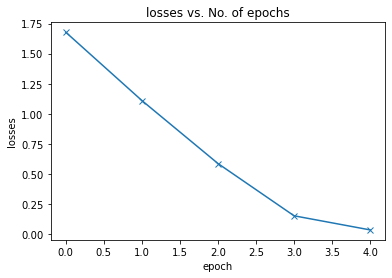

In [177]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [178]:
# Сохраним модель
torch.save(model.state_dict(), './models/model1.pth')

### Тестирование модели

In [179]:
net = ResNet(channels, classes, size_n, size_p, False).to(device)
net.load_state_dict(torch.load('./models/model1.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop11): Dropout(p=0.25, inplace=False)
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, mome

C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


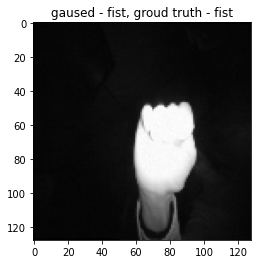

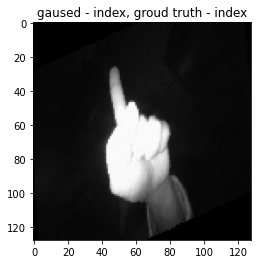

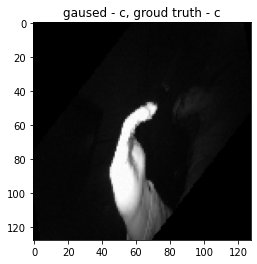

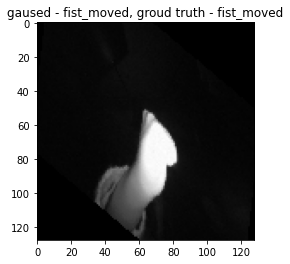

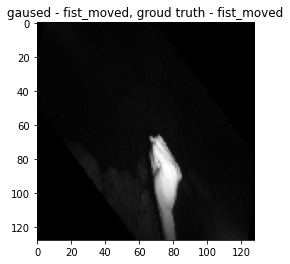

Доля правильно предсказанных жестов: 0.9983333333333333


In [180]:
result = []

with torch.no_grad():
    for i, data in enumerate(loader_test):
        images, labels = data
        images, labels = Variable(images,volatile=True).cuda(), Variable(labels,volatile=True).cuda()
        outputs = net(images)
        result.append(int(outputs[0].argmax() == labels[0]))
        
        if i < 5:
            predict_class = digit_to_classname[int(outputs[0].argmax().detach().cpu().numpy())]
            truth_class = digit_to_classname[int(labels[0].detach().cpu().numpy())]
            plt.title(f'gaused - {predict_class}, groud truth - {truth_class}')
            plt.imshow(images[0].cpu().squeeze(), cmap='gray')
            plt.show()
            
print("Доля правильно предсказанных жестов:", sum(result) / len(result))